# Contextual Bandits with TF-agents







## Learning Objectives

* Learn to load a dataset in BigQuery and connect to it using TensorFlow IO
* Learn how to transform a classification dataset into a contextual bandit problem
* Learn how to stream a BigQuery table into a TensorFlow Dataset
* Learn how to use TensorFlow Agents to define contextual bandit environment
* Learn how to use the neural epsilon-greedy policy to solve a contextual bandit problem
* Learn how to train a contextual bandit agent
* Learn how to predict with a contextual bandit agent

*Contextual Bandit (CB)* is a machine learning framework in which an *agent* selects actions (also called *arms*) in order to maximize rewards in the long term. At each round, the agent receives some information about the current state (also called the *context*) and uses this information to select an action. As a consequence of this choice, it receives a *reward*. 

On the one hand, contextual bandit is one of the simplest instance of a *reinforcement learning problem* where a single state (or context) is provided to the agent and the play or *episode* stops after the first action has been chosen and the reward gotten. This setting appears in a number of useful problems in the industry, one of the best known being that of ad placements on a website: The different ads to publish on a webpage are the different actions, the context is given by a user features, and the reward is 1 if the user clicks on the published ad and 0 otherwise.

On the other hand, contextual bandit is a natural generalization of a classification problem in supervized learning. Namely, consider a data set of points $(x, y)$ where the $x$'s are the features and the $y$'s are the labels in $k$ possible classes. We can setup an associated contextual bandit problem as follows: The CB agent at each time step is given the context $x$. From that information, it needs to select from $k$ possible actions (which are the $k$ possible classes). If the agent chooses the correct class for feature $x$, then the reward is $1$, and it is zero otherwise. The general goal of maximising the long-term cumulative rewards for the CB agent is equivalent to that of minimizing the training loss in supervized learning. Contextual bandit is more general than supervized classification though, since in many useful CB settings we actually know the reward only for the  actions we have taken. 

In this lab, we will learn how to solve a contextual bandit problem derived from a classification dataset with *Q-learning* and the associated *neural epsilon-greedy strategy* using a powerful reinforcement learning library: [TensorFlow Agents](https://www.tensorflow.org/agents). 

**Acknowledgement:** This lab is based on a tutorial originally written by Anant Nawalgaria and Alex Erfurt. We thank them for making their original material available to us.

## Setup

For this lab, you'll first need to build a special kernel containing all the dependencies we will need:

In [ ]:
!cd ~/asl-ml-immersion && make reinforcement_learning_kernel

Then you'll need to select the kernel in the notebook. Click on the current kernel on the top right corner of the notebook:

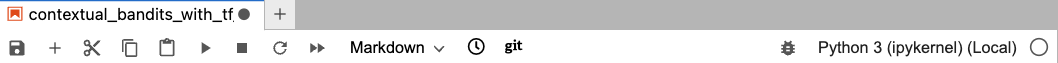

Then select `reinforcement_learning_kernel` in the pop-up selector:

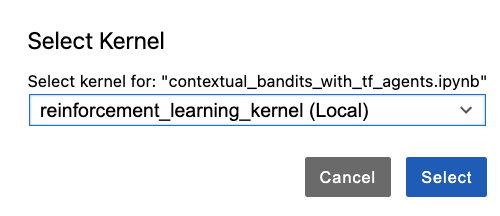

After that you should be able to run the following imports:

In [ ]:
import functools
import os
import time
import warnings

import pandas as pd
import tensorflow as tf  # pylint: disable=g-explicit-tensorflow-version-import

# from tensorflow.python.framework.dtypes import int64
from tensorflow_io.bigquery import BigQueryClient
from tensorflow_probability import distributions as tfd
from tf_agents.bandits.agents.neural_epsilon_greedy_agent import (
    NeuralEpsilonGreedyAgent,
)
from tf_agents.bandits.environments import environment_utilities as env_util
from tf_agents.bandits.environments.classification_environment import (
    ClassificationBanditEnvironment,
)
from tf_agents.bandits.metrics import tf_metrics as tf_bandit_metrics
from tf_agents.drivers.dynamic_step_driver import DynamicStepDriver
from tf_agents.eval import metric_utils
from tf_agents.metrics import tf_metrics
from tf_agents.networks.q_network import QNetwork
from tf_agents.replay_buffers.tf_uniform_replay_buffer import (
    TFUniformReplayBuffer,
)
from tf_agents.trajectories import time_step as ts

In [ ]:
warnings.filterwarnings("ignore")

In [ ]:
REGION = "us-central1"
PROJECT_ID = !(gcloud config get-value project)
PROJECT_ID = PROJECT_ID[0]

os.environ["PROJECT_ID"] = PROJECT_ID

## Loading the dataset into BigQuery

In this lab, we are going to use a classification dataset and turn it into a contextual bandit problem. 

Our dataset will be the [Forest Cover Type from the UCI Machine Learning Repository]( https://archive.ics.uci.edu/ml/datasets/covertype), which associates various cartographic features of a given area with different labels representing different types of forests covering the areas. 

Here are a few rows from the original dataset (the last column is the label):

In [ ]:
pd.read_csv("../../tfx_pipelines/data/dataset.csv").head(2)

At each time step, our CB agent will be given a context $x$ representing an area cartographic features (`Elevation`, `Aspect`, `Slope`, etc.). Then it will have to choose among one of 7 possible forest cover types as defined by the last column (`Cover_type`), and represented by the integer from 0 to 6.

For convenience, we have pre-precessed the categorical features `Wilderness_Area` and `Soil_Type` into their one-hot-encoded versions. So the dataset we will use will have more columns (55 exactly) than the original covertype dataset. We will name the columns corresponding to the 54 features from `X0` to `X54`, while the last column `Y` represents the label.

The next cell defines our dataset column names and column types, and displays a few examples:

In [ ]:
DATASET_SOURCE = "../data/covertype.csv"

df = pd.read_csv(DATASET_SOURCE, header=None)

LABEL_NAME = "Y"
FEATURE_PREFIX = "X"
N_SAMPLES, N_COLUMNS = df.shape

COLUMN_NAMES = [f"{FEATURE_PREFIX}{i}" for i in range(N_COLUMNS - 1)] + [
    LABEL_NAME
]

COLUMN_TYPES = [tf.int64] * N_COLUMNS

df.columns = COLUMN_NAMES
df.head(2)

Let us now load this dataset into `BigQuery` into the table named

```bash
PROJECT_ID.DATASET_ID.TABLE_ID
```

where `DATASET_ID` and `TABLE_ID` are defined in the next cell among other variables like the `DATASET_SCHEMA`:

In [ ]:
DATASET_LOCATION = "US"
DATASET_SCHEMA = ",".join([f"{name}:INTEGER" for name in COLUMN_NAMES])
DATASET_ID = "contextual_bandit"
TABLE_ID = "covertype"

os.environ["DATASET_LOCATION"] = DATASET_LOCATION
os.environ["DATASET_SOURCE"] = DATASET_SOURCE
os.environ["DATASET_SCHEMA"] = DATASET_SCHEMA
os.environ["DATASET_ID"] = DATASET_ID
os.environ["TABLE_ID"] = TABLE_ID

### Exercise

In the cell below, use the [bq command line](https://cloud.google.com/bigquery/docs/bq-command-line-tool) to create the dataset and populate the table from `DATASET_SOURCE` using the variables defined in the cell above:

In [ ]:
%%bash

# TODO
bq --location=$DATASET_LOCATION --project_id=$PROJECT_ID mk --dataset $DATASET_ID

bq --project_id=$PROJECT_ID --dataset_id=$DATASET_ID load \
--source_format=CSV \
--replace \
$TABLE_ID \
$DATASET_SOURCE \
$DATASET_SCHEMA

## Connecting to BigQuery

We will now create a `tf.data.Dataset` connected to the data table we created in `BigQuery`.

For that purpose, we will use [Tensorflow_io](https://github.com/tensorflow/io/tree/v0.15.0/tensorflow_io/bigquery), which offers a connector `BigQueryClient` to  stream data directly out of `BigQuery`:

```python
from tensorflow_io.bigquery import BigQueryClient
```

The first step is to create a`BigQuery` client and then a read session from it:

In [ ]:
bq_client = BigQueryClient()

bq_session = bq_client.read_session(
    f"projects/{PROJECT_ID}",
    PROJECT_ID,
    TABLE_ID,
    DATASET_ID,
    COLUMN_NAMES,
    COLUMN_TYPES,
)

From our `bq_session` we can create a `tf.data.Dataset` using the [parallel_read_rows](https://www.tensorflow.org/io/api_docs/python/tfio/bigquery/BigQueryReadSession#parallel_read_rows) method, which will read our BigQuery rows in parallel: 

In [ ]:
tf_dataset = bq_session.parallel_read_rows(
    block_length=N_SAMPLES,
    num_parallel_calls=tf.data.experimental.AUTOTUNE,
)

At this point the examples are stored in our `tf_dataset` as `OrderedDict` with the keys being the column names and the values being the corresponding row values:

In [ ]:
for example in tf_dataset.take(1):
    print(example)

### Exercise

Configure the `tf_dataset` we instantiated so that
1. the examples are stored as couples $(x, y)$ where $x$ is the feature vector with 54 components and $y$ is the label (**Hint:** Use `.map`)
1. it loops over the dataset infefinitively (**Hint:** Use `.repeat`)
1. it shuffles the dataset (Use `buffer_size=400000`)

In [ ]:
# TODO
def features_and_labels(features):
    label = features.pop(LABEL_NAME)
    return (
        tf.cast(tf.stack(tf.nest.flatten(features), axis=0), tf.float32),
        tf.cast(label - 1, tf.int32),
    )


tf_dataset = (
    tf_dataset.map(features_and_labels).repeat().shuffle(buffer_size=400000)
)

Verify that now the dataset has the correct form:

In [ ]:
for example in tf_dataset.take(1):
    print(example)

## Initializing and configuring the CB environment

In Tensorflow Agents, there are special classes that provide the contexts and the rewards to the agent. These classes are generally called [environments](https://www.tensorflow.org/agents/tutorials/2_environments_tutorial). 

The environment defines the type of actions, states/contexts/observations, and rewards allowed in the problem through its `action_spec`, `observation_spec`, and `reward_spec` methods, respectively. In TensorFlow Agents the environments are specific to a given problem, but the agents are generic. This means that if you want to solve your own RL problem with TensorFlow Agents, you'll likely have to write the environment that represents your problem and define the type of actions and states allowed, but you won't need to implement the agent. Namely, you'll be able to use any of the generic agents in the TensorFlow Agents library. The agent will adapt to your problem setting using `observation_spec`, `action_spec`, and `reward_spec` from your environment.

In this section, we will instanciate the environment to solve our "covertype contextual bandit" problem.

In the TensorFlow Agents library, there is a special environment class named [ClassificationBanditEnvironment](https://www.tensorflow.org/agents/api_docs/python/tf_agents/bandits/environments/classification_environment/ClassificationBanditEnvironment) that  turns any multiclass labeled dataset into a contextual bandit environment. The contexts (or observations) will be the features in the dataset, the actions are the label classes.

In general, the rewards can be sampled from a probability distribution depending on the actual and the guessed labels. 
In our case, the rewards will be deterministic: The agent will receive 1 if it chooses the right class, and 0 otherwise. 

The next cell creates this reward structure using [Tensorflow Probability](https://www.tensorflow.org/probability):

In [ ]:
covertype_reward_distribution = tfd.Independent(
    tfd.Deterministic(tf.eye(7)), reinterpreted_batch_ndims=2
)

If we sample from the distribution above, we obtain a $7\times 7$ identity matrix storing the rewards obtained by the agent if the agent selects class $i$ (corresponding to row $i$) when the actual class is $j$ (corresponding to column $j$). In our case we always obtain the identity matrix:

In [ ]:
covertype_reward_distribution.sample()

### Exercise

Instanciate the [ClassificationBanditEnvironment](https://www.tensorflow.org/agents/api_docs/python/tf_agents/bandits/environments/classification_environment/ClassificationBanditEnvironment) and invoke its `reward_spec`, `observation_spec`, and `action_spec` methods to make sure they correspond to the covertype bandit problem.


Note that the `ClassificationBanditEnvironment` can process many actions in parallel so it takes a `batch_size` argument to define the number of actions it will process simultaneously. Let us set that batch size to 1 for now.


In [ ]:
# TODO: Define the environment
BATCH_SIZE = 1

environment = ClassificationBanditEnvironment(
    tf_dataset, covertype_reward_distribution, BATCH_SIZE
)

In [ ]:
# TODO: Inspect the reward_spec to ensure the reward is scalar float tensors
environment.reward_spec()

In [ ]:
# TODO: Inspect the observation_spec to ensure that the shape=(NUMBER_OF_FEATURE_COLUMNS, )
environment.observation_spec()

In [ ]:
# TODO: Inspect the action_spec to ensure that it is an integer tensor with values in the range [0, 6]
environment.action_spec()

### Exercise

Use the `reset` method on the `environment` you have just instantiated to obtain the first step.
Inspect this step `observation` attribute to see which cartographic features the environment has given you to guess the covertype. Then in a next cell guess a possible covertype from 0 to 6, and pass it to the environment using the `step` method. It will return the next step. Inspect the next step `reward` attribute to see if you guessed correctly.

In [ ]:
# TODO
first_step = environment.reset()
first_step.observation

In [ ]:
# TODO
action = 3
next_step = environment.step(action)
next_step.reward

The next step returned by the environment also contains the new context:

In [ ]:
next_step.observation

## Initializing the Agent

In Tensorflow Agents, the classes that implement algorithms to solve contextual bandit problems are called *agents*.   

In this lab, we will will use the [NeuralEpsilonGreedyAgent](https://medium.com/analytics-vidhya/the-epsilon-greedy-algorithm-for-reinforcement-learning-5fe6f96dc870), which implements the *neural epsilon greedy algorithm*.

This algorithm predicts the reward for each possible action given a context as input using a neural network. This network is called a [Q-Network](https://www.tensorflow.org/agents/api_docs/python/tf_agents/networks/q_network/QNetwork), since it outputs the $Q$-values $Q(x, a)$ for each of the actions $a$, which are the predicted rewards for each of the actions $a$ given the input context $x$.

The action is then chosen to be the one with maximal $Q$-value $1-\epsilon$ of the time, or a random action with probability $\epsilon$. This randomness allows the algorithm to explore states that could be promising even though the neural network may estimate their rewards poorly. 


### Exercise

Instanciate a [Q-Network](https://www.tensorflow.org/agents/api_docs/python/tf_agents/networks/q_network/QNetwork) so that it takes 
* as input tensor an observation tensor as defined by the environment 
* as output tensor an action tensor as defined by the environment


Configure the structure of the layers as you wish.

In [ ]:
# TODO
LAYERS = (300, 200, 100, 100, 50, 50)

network = QNetwork(
    input_tensor_spec=environment.observation_spec(),
    action_spec=environment.action_spec(),
    fc_layer_params=LAYERS,
)

### Exercise

Generate a step from the environment using its `step`method, and feed its observation attribute to the $Q$-network.
Verify that the tensor of $Q$-values you are getting is of the right shape (you should get a vector with 7 components containing the predicted reward for each of the covertype classes):

In [ ]:
# TODO
action = 2
step = environment.step(action)
q_values = network(step.observation)
q_values

### Exercise

Now that we have our `QNetwork` to estimate our action rewards, in the next cell, you will instanciate the agent from the [NeuralEpsilonGreedyAgent](https://www.tensorflow.org/agents/api_docs/python/tf_agents/bandits/agents/neural_epsilon_greedy_agent/NeuralEpsilonGreedyAgent) class. You will need to retrieve the `time_step_spec` and the `action_spec` from the environment. The `reward_network` will be the `QNetwork` you instantiated previously. You can take `Adam` as optimizer with a `LEARNING_RATE` of your choice. 
You will also set the propensity of your agent to explore rather than exploit the action with highest predicted reward through the value of `EPSILON`. Both the `LEARNING_RATE` and the `EPSILON` greediness are hyper-paramaters that can affect the training of the agent very much.

In [ ]:
EPSILON = 0.01
LEARNING_RATE = 0.002

# TODO
agent = NeuralEpsilonGreedyAgent(
    time_step_spec=environment.time_step_spec(),
    action_spec=environment.action_spec(),
    reward_network=network,
    optimizer=tf.compat.v1.train.AdamOptimizer(LEARNING_RATE),
    epsilon=EPSILON,
)


The agent has a `policy` attribute containing the strategy that the agent will use when confronted to a given context. The `agent.policy` has an`action` method that takes in a `TimeStep` generated by the environment and containing the context. It then issues a `PolicyStep` containing the action chosen by the policy given this context:

In [ ]:
policy_step = agent.policy.action(step)
policy_step.action

Under the hood, the agent policy uses the `QNetwork` to predict the values of the different actions (or possible covertype classes in our case). However at this stage the `QNetwork` has not been trained and its weights are random. This means that the predicted classes are meaningless.

To remediate that, the agent has a `train` method that takes an experience, that is, a triples of a state (or context) $x$, the action taken (or predicted class) $y$, and the obtained reward $r$. It then updates the parameters $\theta$ of the `QNetwork` $Q_\theta$ with a gradient update so that the predicted reward $Q_\theta(x, y)$ used by the agent to guess $y$ in context $x$ increases if $y$ is the correct class (i.e. reward $1$) and decreases if $y$ has been guessed wrongly.

Now training one experience at a time may lead to an unstable training, and the algorithm may have difficulty to converge. To stabilize the training one collects a number of these experiences in a *experience replay buffer* in a first stage, and then sample batches of these experiences to apply the gradient update to the `QNetwork` parameters in a second stage, as we do in supervized learning. 

## Collecting experiences in an experience replay buffer

Reinforcement learning algorithms use experience replay buffers to store trajectories of experiences when executing a policy in an environment. During training, replay buffers are queried for a subset of the trajectories to "replay" the agent's experience. Sampling from the replay buffer facilitates data re-use and breaks harmful co-relations between sequential data in RL, although in contextual bandits this isn't absolutely required but still helpful to stabilize the training.

Tensorflow Agents defines a number of [replay buffer classes](https://www.tensorflow.org/agents/tutorials/5_replay_buffers_tutorial) all sharing a common interface to store and access the experience data. In this lab, we will use [TFUniformReplayBuffer](https://www.tensorflow.org/agents/api_docs/python/tf_agents/replay_buffers/TFUniformReplayBuffer) which samples uniformly experience trajectories. 

## Exercise


Initialize a [TFUniformReplayBuffer](https://www.tensorflow.org/agents/api_docs/python/tf_agents/replay_buffers/TFUniformReplayBuffer)  using for `data_spec` the `trajectory_spec` stored in the agent's policy. Then use a `batch_size` of 1, which will be the size of the batches sampled from the replay buffer for each gradient descent update. The`max_length` argument indicates the maximum number of steps we allow to be stored in the replay buffer from a single episode. Since for CB the eposide size is always 1, you'll set this argument to that. 


In [ ]:
# TODO

replay_buffer = TFUniformReplayBuffer(
    data_spec=agent.policy.trajectory_spec,
    batch_size=1,
    max_length=1,
)

Now we have a Replay buffer, but we also need something to fill it with. Often a common practice is to have 
the agent interact with and collect experiences from the environment, without actually learning from it (that is without updating the parameters of the `QNetwork`) in a first step. 

This data-collection loop can be carried out using a [DynamicStepDriver](https://www.tensorflow.org/agents/api_docs/python/tf_agents/drivers/dynamic_step_driver/DynamicStepDriver), which will 
1. feed the `TimeStep` generated by the environment and containing the context data for the new step and the reward for the previous step to the agent,
1. collect the action generated by the agent policy from the environment context, and then 
1. feed that action back to the environment.  

All that repeated in a loop. 

The data encountered by the driver at each step is saved in a `NamedTuple` called [Trajectory](https://www.tensorflow.org/agents/api_docs/python/tf_agents/trajectories/Trajectory) and broadcast to a set of observers such as replay buffers. 
This trajectory includes the observation from the environment, the action recommended by the policy, the reward obtained, the type of the current and the next step, etc. 

In order for the driver to fill the replay buffer with data it needs acess to the [add_batch method](https://www.tensorflow.org/agents/tutorials/5_replay_buffers_tutorial#data_collection) of the replay buffer.


## Exercise

Instanciate a [DynamicStepDriver](https://www.tensorflow.org/agents/api_docs/python/tf_agents/drivers/dynamic_step_driver/DynamicStepDriver) using the environment we used so far. Note that the agent has two different policies:
*  the `agent.policy` which is the *exploitation policy* that outputs the action with maximal predicted reward. This is the policy that should be deployed inthe production environment.
* the `agent.collect_policy` which is the *exploration policy* that outputs the maximal reward action only $1 - \epsilon$ of the time, allowing for exploring a wider range of actions. This is the policy that is the most beneficial to use to collect training data, and the one that the `DynmicStepDriver` needs to use.

(Note that both of these policies use the same underlying `QNetwork`; only the final action choice from the computed $Q$-values is different.)

In [ ]:
# TODO
observer = [replay_buffer.add_batch]

driver = DynamicStepDriver(
    env=environment,
    policy=agent.collect_policy,
    num_steps=100,
    observers=observer,
)

The `driver.run` method will then start making the agent interact with the environment, while its sends experience trajectories to the replay buffer. Once done, one can retrieve the collected experience data from the replay buffer by invoking its `as_dataset` method:

In [ ]:
driver.run()

replay_dataset = replay_buffer.as_dataset(
    sample_batch_size=BATCH_SIZE,
    num_steps=1,
    single_deterministic_pass=True,
)

Training the agent now amounts to retrieve (batches of) experience data from the `replay_dataset` and feed that data to the agent `train` method:

In [ ]:
experience, _ = next(iter(replay_dataset))

loss_info = agent.train(experience)
loss_info

## Training the agent

We are almost ready now to write our contextual bandit agent training loop. Before we do that, let us recap what we have done so far, and configure all the objects anew for the real training. First of all, let us gather all the constants we have defined until this point in the same cell, and let us add a few which will be useful for saving our trained policy:

In [ ]:
BATCH_SIZE = 128
LAYERS = (300, 200, 100, 100, 50, 50)
EPSILON = 0.01
LEARNING_RATE = 0.002

TRAINING_LOOPS = 150
STEPS_PER_LOOP = 1
AGENT_ALPHA = 10.0

AGENT_CHECKPOINT_NAME = "agent"
STEP_CHECKPOINT_NAME = "step"
CHECKPOINT_FILE_PREFIX = "ckpt"

TIMESTAMP = time.strftime("%Y%m%d_%H%M%S")
ROOT_DIR = f"./contextual_bandit_checkpoints/{TIMESTAMP}"

The next cell instanciates anew the contextual bandit main players (i.e., the environment, the neural network, the agent, and the experience replay buffer) so that we can have a global view of the process:

In [ ]:
covertype_reward_distribution = tfd.Independent(
    tfd.Deterministic(tf.eye(7)), reinterpreted_batch_ndims=2
)

environment = ClassificationBanditEnvironment(
    tf_dataset, covertype_reward_distribution, BATCH_SIZE
)

network = QNetwork(
    input_tensor_spec=environment.observation_spec(),
    action_spec=environment.action_spec(),
    fc_layer_params=LAYERS,
)

agent = NeuralEpsilonGreedyAgent(
    time_step_spec=environment.time_step_spec(),
    action_spec=environment.action_spec(),
    reward_network=network,
    optimizer=tf.compat.v1.train.AdamOptimizer(LEARNING_RATE),
    epsilon=EPSILON,
)

replay_buffer = TFUniformReplayBuffer(
    data_spec=agent.policy.trajectory_spec,
    batch_size=BATCH_SIZE,
    max_length=STEPS_PER_LOOP,
)

During training it is very useful to collect various metrics on the top of the training loss so that we can assess whether the training was effective or not from the plot of their learning curves.

Just like you have metrics such as accuracy or recall in supervised learning, in bandit problems we use the [regret metric per episode](https://www.tensorflow.org/agents/tutorials/bandits_tutorial#regret_metric). To calculate the regret, we need to know what the highest possible expected reward is at every time step. The regret is essentially the difference between the highest reward we could have gotten and the reward we obtained summed up over our experience. As training progress, we expect the regret to decrease. 

To compute the regret, we need to define the `optimal_reward_fn` using

```python
env_util.compute_optimal_reward_with_classification_environment
```
which can know the optimal reward at each time step from the environment. 

Another similar metric is the number of times a suboptimal action has been chosen. That requires the definition if the `optimal_action_fn` in the same way.

In the cell below, we collect all these metrics in the `metrics` list:
* `RegretMetric` - Computes the regret with respect to a baseline (ex: `optimal_reward_fn`)
* `SubOptimalArmsMetric` - Computes the number of suboptimal arms with respect to a baseline (ex: `optimal_action_fn`)
* `NumberOfEpisode` - Keeps track of the number of episode so far
* `AveratgeReturnMetric` - Computes the average return so far

In [ ]:
optimal_reward_fn = functools.partial(
    env_util.compute_optimal_reward_with_classification_environment,
    environment=environment,
)

optimal_action_fn = functools.partial(
    env_util.compute_optimal_action_with_classification_environment,
    environment=environment,
)

step_metric = tf_metrics.EnvironmentSteps()

metrics = [
    tf_metrics.NumberOfEpisodes(),
    tf_bandit_metrics.RegretMetric(optimal_reward_fn),
    tf_bandit_metrics.SuboptimalArmsMetric(optimal_action_fn),
    tf_metrics.AverageReturnMetric(batch_size=environment.batch_size),
]

At each step of the training loop, we will compute the overall value for each of the metrics from the experience generated by the driver.
To broadcast that experience data generated by the driver to the metrics, we can include these metrics to the list of `observers` that the driver broadcasts experience to. So now our `observers` list will contain the replay buffer `add_batch` method as well as all the metrics we defined above:

In [ ]:
observers = [replay_buffer.add_batch, step_metric] + metrics

driver = DynamicStepDriver(
    env=environment,
    policy=agent.collect_policy,
    num_steps=STEPS_PER_LOOP * environment.batch_size,
    observers=observers,
)

We are almost ready for the training loop! We need a couple of things though to help us save our model and metrics first though before that. Below we provide you with a helper function in order to save your agent and its the metrics, while training the model. For more information on checkpoints and policy savers (which will be used in the training loop below) go [here](https://www.tensorflow.org/agents/tutorials/10_checkpointer_policysaver_tutorial).

In [ ]:
def restore_and_get_checkpoint_manager(root_dir, agent, metrics, step_metric):
    """Restores from `root_dir` and returns a function that writes checkpoints."""
    trackable_objects = {metric.name: metric for metric in metrics}
    trackable_objects[AGENT_CHECKPOINT_NAME] = agent
    trackable_objects[STEP_CHECKPOINT_NAME] = step_metric
    checkpoint = tf.train.Checkpoint(**trackable_objects)
    checkpoint_manager = tf.train.CheckpointManager(
        checkpoint=checkpoint, directory=root_dir, max_to_keep=5
    )
    latest = checkpoint_manager.latest_checkpoint

    if latest is not None:
        print("Restoring checkpoint from %s.", latest)
        checkpoint.restore(latest)
        print("Successfully restored to step %s.", step_metric.result())
    else:
        print(
            "Did not find a pre-existing checkpoint. " "Starting from scratch."
        )
    return checkpoint_manager


checkpoint_manager = restore_and_get_checkpoint_manager(
    ROOT_DIR, agent, metrics, step_metric
)
summary_writer = tf.summary.create_file_writer(ROOT_DIR)
summary_writer.set_as_default()

## Exercise

Now we have all the components ready to start training the model.

A step in the training loop follows the following sequence:
1. Run the driver to store experience in the replay buffer
1. Generate a `tf.data.Dataset` from the replay buffer using its `as_dataset` method
1. Obtain a batch of experience by iterating once over the replay dataset
1. Use `agent.train` to train the agent with the experience batch and log the loss
1. Clear the replay buffer and log the metrics 

With that in mind, complete the training loop below:

In [ ]:
# TODO
for _ in range(TRAINING_LOOPS):
    driver.run()
    batch_size = driver.env.batch_size

    dataset = replay_buffer.as_dataset(
        sample_batch_size=BATCH_SIZE,
        num_steps=STEPS_PER_LOOP,
        single_deterministic_pass=True,
    )

    experience, _ = next(iter(dataset))

    train_loss = agent.train(experience).loss

    replay_buffer.clear()

    metric_utils.log_metrics(metrics)

    for metric in metrics:
        metric.tf_summaries(train_step=step_metric.result())
    checkpoint_manager.save()

## Visualizing the learning curves with TensorBoard

Now that the model has trained, we want to visualize the learning curve. For that we will use tensorboard, since we have saved each of the metrics as Tensorboard events with the checkpoint manager. 

Let us upload the Tensorboard logs to [tensorboard.dev](https://tensorboard.dev/); to do that:
* execute the cell below that will generate a bash command
* copy this command, open a terminal in JupyterLab, and paste this command
* follow the authentication instructions

In [ ]:
!echo tensorboard dev upload --logdir $(cd $ROOT_DIR && pwd)

You should see something like this if all has gone well:

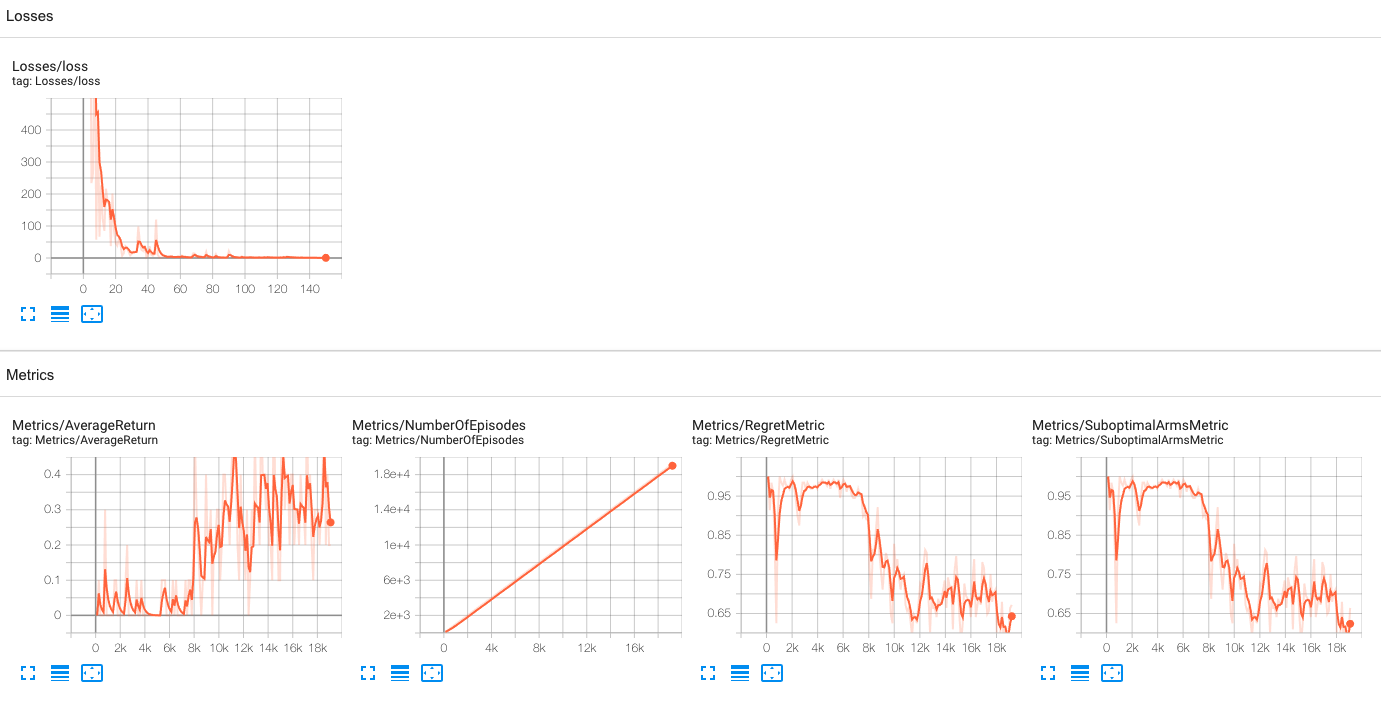

**Remark:** The $x$-axis in the loss graph represents the number of steps in the global training loop, that is,  `TRAINING_LOOPS`, while for the metrics graph the same $x$-axis represent the total number of episode generated, that is, `TRAINING_LOOPS * STEPS_PER_LOOP * BATCH_SIZE`.

## Predicting with our trained contextual bandit

Now that our model is trained, what if we want to determine which action to take given a new context.

For that we start by iterating over our dataset to get a context: 

In [ ]:
feature, label = iter(tf_dataset).next()

Because our trained agent consumes `TimeStep`, we need to wrap the raw feature using `ts.TimeStep`, which expects `step_type`, `reward`, `discount`, and `observation` as input. Since we are in prediction mode `now`, `reward`, and `discount` are irrelant and can be assigned any arbitary values (see [here](https://www.tensorflow.org/agents/api_docs/python/tf_agents/trajectories/time_step/TimeStep) for more details): 

In [ ]:
step = ts.TimeStep(
    tf.constant(ts.StepType.FIRST, dtype=tf.int32, shape=[1], name="step_type"),
    tf.constant(0.0, dtype=tf.float32, shape=[1], name="reward"),
    tf.constant(1.0, dtype=tf.float32, shape=[1], name="discount"),
    tf.constant(feature, dtype=tf.float32, shape=[1, 54], name="observation"),
)

At last,let us get the recommeded action from our trained agent:       

In [ ]:
policy_step = agent.policy.action(step)
policy_step.action.numpy()[0]

Copyright 2022 Google LLC

Licensed under the Apache License, Version 2.0 (the "License");
you may not use this file except in compliance with the License.
You may obtain a copy of the License at

    https://www.apache.org/licenses/LICENSE-2.0

Unless required by applicable law or agreed to in writing, software
distributed under the License is distributed on an "AS IS" BASIS,
WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
See the License for the specific language governing permissions and
limitations under the License.